Лабораторна робота №6
Студента СА-43
Мозоля Назарія

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -o ./drive/MyDrive/DeepL/archive1.zip -d ./dataset

Archive:  ./drive/MyDrive/DeepL/archive1.zip
  inflating: ./dataset/test.txt      
  inflating: ./dataset/train.txt     
  inflating: ./dataset/val.txt       


In [ ]:
!pip install keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 32.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Suc

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix,f1_score, roc_auc_score,roc_curve, auc
import itertools
import time
import pandas as pd
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer
from keras import models
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, f1_score
from keras.layers import TextVectorization, Embedding, Dense, GlobalMaxPooling1D, Conv1D, Input, Dropout
from keras.models import Model
from keras_nlp.layers import TransformerEncoder


# Checks for available GPUs and lists them
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Set TensorFlow to use only the first GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 1 Logical GPU


In [ ]:
df_train = pd.read_csv("./dataset/train.txt", sep=";", header=None, names=['Text', 'Emotion'])
df_test = pd.read_csv("./dataset/test.txt", sep=";", header=None, names=['Text', 'Emotion'])
df_val = pd.read_csv("./dataset/val.txt", sep=";", header=None, names=['Text', 'Emotion'])

In [ ]:
df_train.value_counts()
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


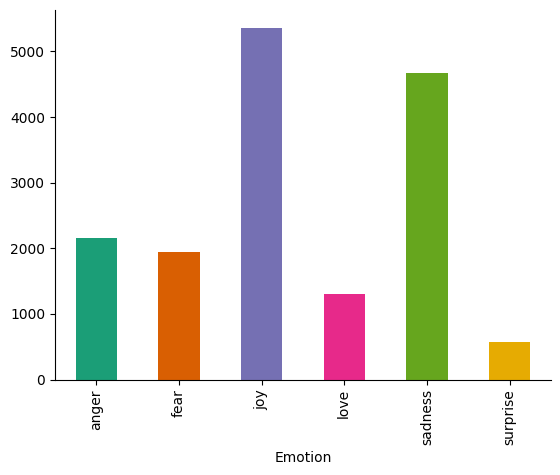

In [ ]:
emotions = df_train['Emotion'].unique().tolist()

df_train.groupby('Emotion').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
emotions

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

Preproccess

In [ ]:
# nltk.download('wordnet')
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# lemmatizer = WordNetLemmatizer()


# def preprocess_text(text):
#     text=text.lower()
#     tokens_dict = tokenizer(text)
#     tokens = tokens_dict['input_ids']
#     tokens = [str(token) for token in tokens]
#     tokens = [lemmatizer.lemmatize(token) for token in tokens]
#     return ' '.join(tokens)

# df_train['Text1'] = df_train['Text'].apply(preprocess_text)
# df_test['Text1'] = df_test['Text'].apply(preprocess_text)
# df_val['Text1'] = df_val['Text'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
nltk.download('wordnet')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    text=text.lower()
    tokens_dict = tokenizer(text)
    tokens = tokens_dict['input_ids']
    tokens = [str(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df_train['Text1'] = df_train['Text'].apply(preprocess_text)
df_test['Text1'] = df_test['Text'].apply(preprocess_text)
df_val['Text1'] = df_val['Text'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df_train

,Text,Emotion,Text1
0,i didnt feel humiliated,sadness,101 1045 2134 2102 2514 26608 102
1,i can go from feeling so hopeless to so damned...,sadness,101 1045 2064 2175 2013 3110 2061 20625 2000 2...
2,im grabbing a minute to post i feel greedy wrong,anger,101 10047 9775 1037 3371 2000 2695 1045 2514 2...
3,i am ever feeling nostalgic about the fireplac...,love,101 1045 2572 2412 3110 16839 9080 12863 2055 ...
4,i am feeling grouchy,anger,101 1045 2572 3110 24665 7140 11714 102
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101 1045 2074 2018 1037 2200 4766 2051 1999 19...
15996,i am now turning and i feel pathetic that i am...,sadness,101 1045 2572 2085 3810 1998 1045 2514 17203 2...
15997,i feel strong and good overall,joy,101 1045 2514 2844 1998 2204 3452 102
15998,i feel like this was such a rude comment and i...,anger,101 1045 2514 2066 2023 2001 2107 1037 12726 7...


In [ ]:
x_train, y_train = df_train['Text1'], df_train['Emotion']
x_test, y_test = df_test['Text1'], df_test['Emotion']
x_val, y_val = df_val['Text1'], df_val['Emotion']

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(emotions)

y_train = tf.keras.utils.to_categorical(label_encoder.transform(y_train), num_classes=len(emotions))
y_test = tf.keras.utils.to_categorical(label_encoder.transform(y_test), num_classes=len(emotions))
y_val = tf.keras.utils.to_categorical(label_encoder.transform(y_val), num_classes=len(emotions))

In [ ]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [ ]:
def plot_learning_curve(history, figsize=(10, 5)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    axs[0].plot(history.history['accuracy'], color='#b8113d')
    axs[0].plot(history.history['val_accuracy'], color='#6010b5')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(history.history['loss'], color='#b8113d')
    axs[1].plot(history.history['val_loss'], color='#6010b5')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

In [ ]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience = 3, min_lr=0.000001)]

Model 1(only FC)

In [ ]:
vector = layers.TextVectorization(max_tokens=10000, output_mode='tf_idf')
vector.adapt(tf.data.Dataset.from_tensor_slices(x_train).batch(32))

In [ ]:
model1 = models.Sequential([
    vector,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(emotions), activation='softmax')
])

model1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics=['accuracy']
)

In [ ]:
start_time1 = time.time()

hist1 = model1.fit(
    x = x_train,
    y = y_train,
    epochs = 60,
    batch_size = 128,
    callbacks = callback,
    validation_data = (x_val, y_val)
)

end_time1 = time.time()

Epoch 1/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9896 - loss: 0.4960 - val_accuracy: 0.8775 - val_loss: 0.7017 - learning_rate: 3.0000e-05
Epoch 2/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9898 - loss: 0.4965 - val_accuracy: 0.8800 - val_loss: 0.7016 - learning_rate: 3.0000e-05
Epoch 3/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9893 - loss: 0.4934 - val_accuracy: 0.8770 - val_loss: 0.7006 - learning_rate: 3.0000e-05
Epoch 4/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9897 - loss: 0.4915 - val_accuracy: 0.8775 - val_loss: 0.7005 - learning_rate: 3.0000e-05
Epoch 5/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9912 - loss: 0.4887 - val_accuracy: 0.8780 - val_loss: 0.7008 - learning_rate: 3.0000e-05
Epoch 6/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9905 - loss: 0.4874 - val_accuracy: 0.8785 - val_loss: 0.7002 - learning_rate: 3.0000e-05
Epoch 7/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accu

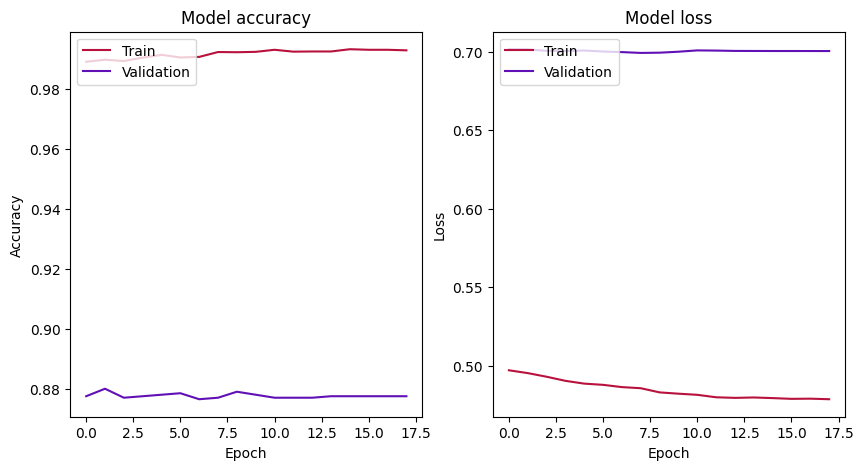

In [ ]:
plot_learning_curve(hist1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<Axes: >

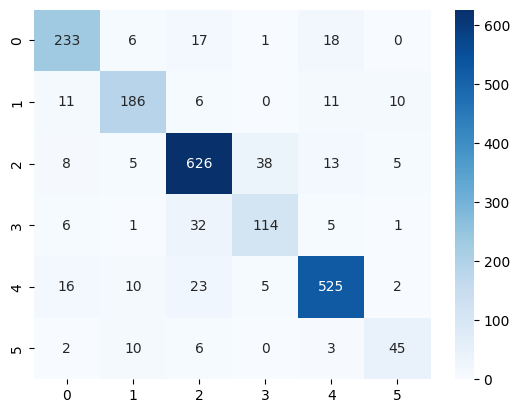

In [ ]:
y_pred1 = model1.predict(x_test)
y_pred1_uint8 = np.argmax(y_pred1, axis=1).astype(np.uint8)
y_test1_unit8 = np.argmax(y_test, axis=1).astype(np.uint8)


sns.heatmap(confusion_matrix(y_test1_unit8, y_pred1_uint8), annot=True, cmap='Blues', fmt='d')

In [ ]:
print("Classification Report:")
print(classification_report(y_test1_unit8, y_pred1_uint8))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       275
           1       0.85      0.83      0.84       224
           2       0.88      0.90      0.89       695
           3       0.72      0.72      0.72       159
           4       0.91      0.90      0.91       581
           5       0.71      0.68      0.70        66

    accuracy                           0.86      2000
   macro avg       0.82      0.81      0.82      2000
weighted avg       0.86      0.86      0.86      2000



Model 2(CNN-like head)

In [ ]:
vector2 = layers.TextVectorization(max_tokens=10000)
vector2.adapt(tf.data.Dataset.from_tensor_slices(x_train).batch(32))

In [ ]:
class FeatureExtractor(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        feature_extraction_layer = Conv1D(64, 5, activation='relu')

        self.feature_extractor = tf.keras.Sequential([
          Embedding(input_dim=10000, output_dim=32),
          feature_extraction_layer,
          GlobalMaxPooling1D()
        ])

    def call(self, inputs):
        return self.feature_extractor(inputs)

In [ ]:
class ClassificationHead(layers.Layer):
    def __init__(self, num_classes:int, name=None):
        super().__init__(name=name)
        self.classification_head = tf.keras.Sequential([
          layers.Dense(128, activation='relu'),
          layers.Dropout(0.2),
          layers.Dense(128, activation='relu'),
          layers.Dropout(0.2),
          layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        return self.classification_head(inputs)

In [ ]:
class TextClassifier(Model):
    def __init__(self,
                 num_classes:int,
                 vectorizer: TextVectorization):
        super().__init__()
        self.vectorizer = vectorizer
        self.feature_extractor = FeatureExtractor(name='feature_extractor')
        self.classifier = ClassificationHead(num_classes=num_classes,
                                             name='classification_head')

    def call(self, inputs):
        return self.classifier(self.feature_extractor(self.vectorizer(inputs)))

In [ ]:
model2 = TextClassifier(num_classes=len(emotions),
                            vectorizer=vector2)
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
start_time2 = time.time()

hist2 = model2.fit(
    x = x_train,
    y = y_train,
    epochs = 60,
    batch_size = 128,
    callbacks = callback,
    validation_data = (x_val, y_val)
)

end_time2 = time.time()

Epoch 1/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3383 - loss: 1.6140 - val_accuracy: 0.6000 - val_loss: 1.0656 - learning_rate: 0.0010
Epoch 2/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7337 - loss: 0.7384 - val_accuracy: 0.8930 - val_loss: 0.3500 - learning_rate: 0.0010
Epoch 3/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9235 - loss: 0.2138 - val_accuracy: 0.9060 - val_loss: 0.2727 - learning_rate: 0.0010
Epoch 4/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9579 - loss: 0.1180 - val_accuracy: 0.9150 - val_loss: 0.2651 - learning_rate: 0.0010
Epoch 5/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9785 - loss: 0.0658 - val_accuracy: 0.9180 - val_loss: 0.2992 - learning_rate: 0.0010
Epoch 6/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9853 - loss: 0.0454 - val_accuracy: 0.9115 - val_loss: 0.3109 - learning_rate: 0.0010
Epoch 7/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9911 - loss: 0.0280 -

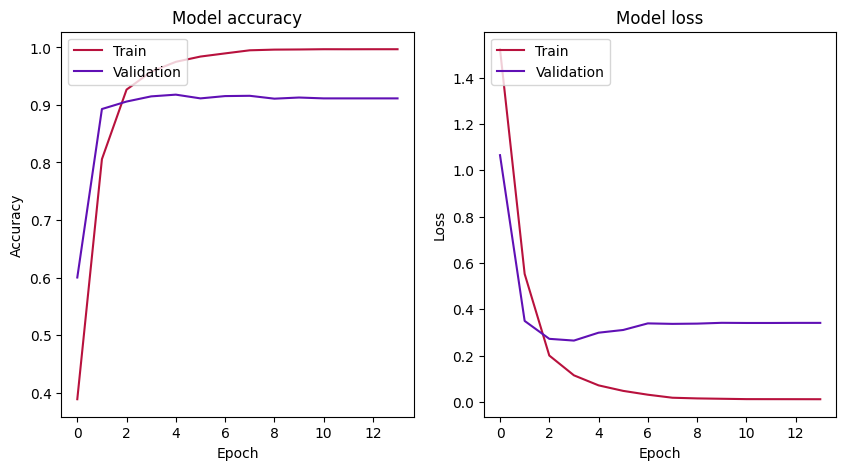

In [ ]:
plot_learning_curve(hist2)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


<Axes: >

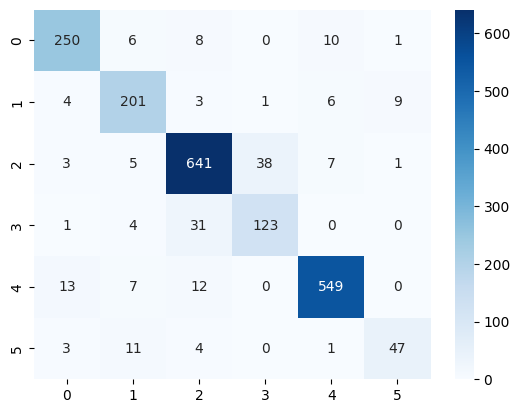

In [ ]:
y_pred2 = model2.predict(x_test)
y_pred2_uint8 = np.argmax(y_pred2, axis=1).astype(np.uint8)
y_test2_unit8 = np.argmax(y_test, axis=1).astype(np.uint8)

sns.heatmap(confusion_matrix(y_test2_unit8, y_pred2_uint8), annot=True, cmap='Blues', fmt='d')

In [ ]:
print("Classification Report:")
print(classification_report(y_test2_unit8, y_pred2_uint8))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       275
           1       0.86      0.90      0.88       224
           2       0.92      0.92      0.92       695
           3       0.76      0.77      0.77       159
           4       0.96      0.94      0.95       581
           5       0.81      0.71      0.76        66

    accuracy                           0.91      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.91      0.91      0.91      2000



Model 3(TransformerEncoder based)

In [ ]:
vector3 = layers.TextVectorization(max_tokens=10000)
vector3.adapt(tf.data.Dataset.from_tensor_slices(x_train).batch(32))

In [ ]:
class FeatureExtractor1(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        feature_extraction_layer = TransformerEncoder(num_heads=2, intermediate_dim=64)

        self.feature_extractor = tf.keras.Sequential([
          Embedding(input_dim=10000, output_dim=32),
          feature_extraction_layer,
          GlobalMaxPooling1D()
        ])

    def call(self, inputs):
        return self.feature_extractor(inputs)

In [ ]:
class ClassificationHead(layers.Layer):
    def __init__(self, num_classes:int, name=None):
        super().__init__(name=name)
        self.classification_head = tf.keras.Sequential([
          Dense(128, activation='relu'),
          Dropout(0.5),
          Dense(units=num_classes, activation='softmax')
        ])

    def call(self, inputs):
        return self.classification_head(inputs)

In [ ]:
class TextClassifier1(Model):
    def __init__(self,
                 num_classes:int,
                 vectorizer: TextVectorization):
        super().__init__()
        self.vectorizer = vectorizer
        self.feature_extractor = FeatureExtractor1(name='feature_extractor')
        self.classifier = ClassificationHead(num_classes=num_classes,
                                             name='classification_head')

    def call(self, inputs):
        return self.classifier(self.feature_extractor(self.vectorizer(inputs)))

In [ ]:
model3 = TextClassifier1(num_classes=len(emotions),
                        vectorizer=vector3)
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
start_time3 = time.time()

hist3 = model3.fit(
    x = x_train,
    y = y_train,
    epochs = 60,
    batch_size = 128,
    callbacks = callback,
    validation_data = (x_val, y_val)
)

end_time3 = time.time()

Epoch 1/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9947 - loss: 0.0227 - val_accuracy: 0.8870 - val_loss: 0.3351 - learning_rate: 1.0000e-05
Epoch 2/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9948 - loss: 0.0231 - val_accuracy: 0.8885 - val_loss: 0.3353 - learning_rate: 1.0000e-05
Epoch 3/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9960 - loss: 0.0221 - val_accuracy: 0.8890 - val_loss: 0.3356 - learning_rate: 1.0000e-05
Epoch 4/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9943 - loss: 0.0238 - val_accuracy: 0.8890 - val_loss: 0.3362 - learning_rate: 1.0000e-05
Epoch 5/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9941 - loss: 0.0240 - val_accuracy: 0.8890 - val_loss: 0.3362 - learning_rate: 1.0000e-06
Epoch 6/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9953 - loss: 0.0221 - val_accuracy: 0.8890 - val_loss: 0.3362 - learning_rate: 1.0000e-06
Epoch 7/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - acc

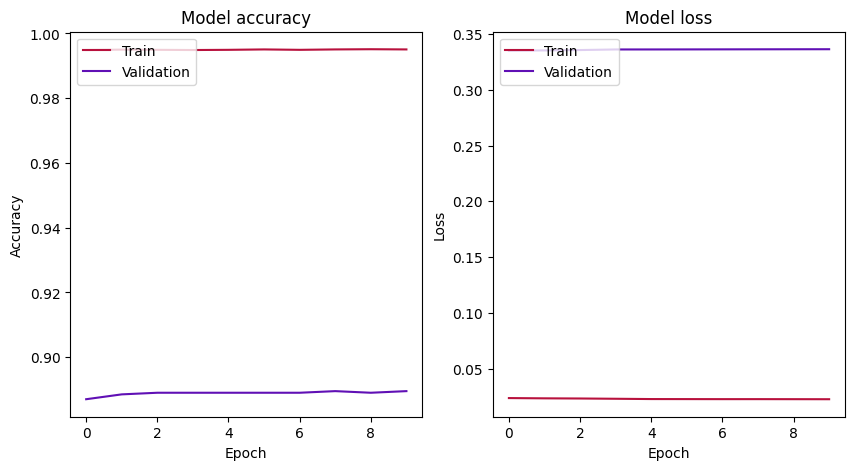

In [39]:
plot_learning_curve(hist3)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


<Axes: >

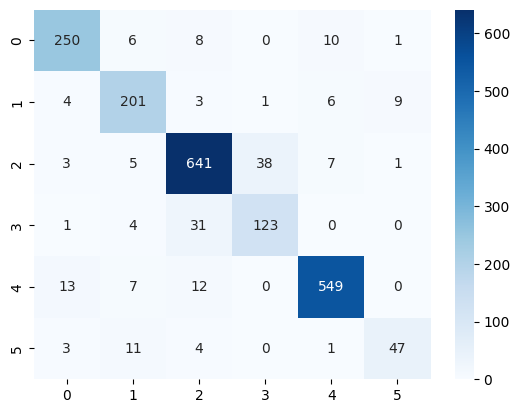

In [45]:
y_pred3 = model3.predict(x_test)
y_pred3_uint8 = np.argmax(y_pred3, axis=1).astype(np.uint8)
y_test3_unit8 = np.argmax(y_test, axis=1).astype(np.uint8)


sns.heatmap(confusion_matrix(y_test2_unit8, y_pred2_uint8), annot=True, cmap='Blues', fmt='d')

In [46]:
print("Classification Report:")
print(classification_report(y_test3_unit8, y_pred3_uint8))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       275
           1       0.87      0.84      0.85       224
           2       0.90      0.93      0.91       695
           3       0.78      0.75      0.76       159
           4       0.90      0.93      0.91       581
           5       0.75      0.64      0.69        66

    accuracy                           0.88      2000
   macro avg       0.85      0.82      0.83      2000
weighted avg       0.88      0.88      0.88      2000



Comparing results

In [47]:
train_time1 = start_time1 - end_time1
train_time2 = start_time2 - end_time2
train_time3 = start_time3 - end_time3

print("Training time of model 1: {:.2f} seconds".format(-train_time1))
print("Training time of model 2: {:.2f} seconds".format(-train_time2))
print("Training time of model 3: {:.2f} seconds".format(-train_time3))

Training time of model 1: 27.40 seconds
Training time of model 2: 22.46 seconds
Training time of model 3: 30.43 seconds


In [48]:
y_pred1_labels = np.argmax(y_pred1, axis=1)
y_pred2_labels = np.argmax(y_pred2, axis=1)
y_pred3_labels = np.argmax(y_pred3, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

f1_score1 = f1_score(y_test_labels, y_pred1_labels, average='micro')
f1_score2 = f1_score(y_test_labels, y_pred2_labels, average='micro')
f1_score3 = f1_score(y_test_labels, y_pred3_labels, average='micro')

print("F1 Score for model 1:", f1_score1)
print("F1 Score for model 2:", f1_score2)
print("F1 Score for model 3:", f1_score3)

F1 Score for model 1: 0.8645
F1 Score for model 2: 0.9055
F1 Score for model 3: 0.8835000000000001


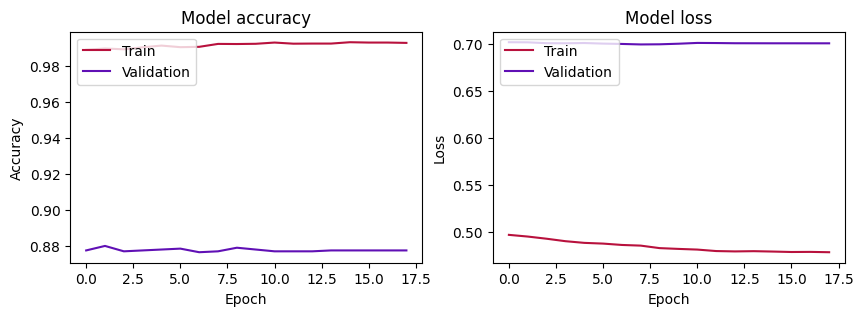

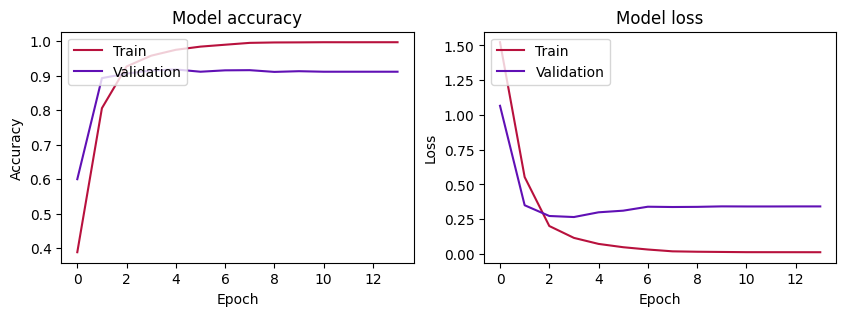

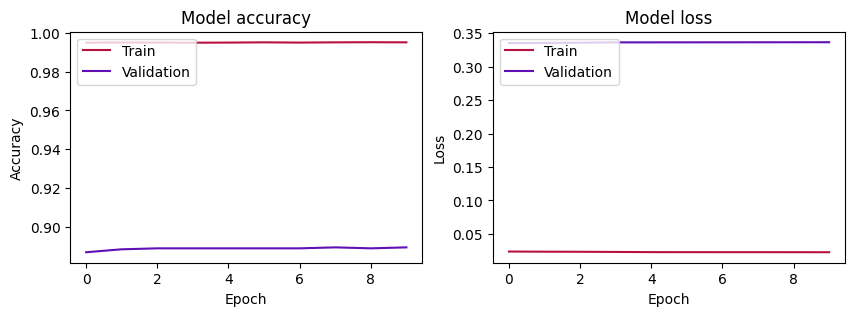

In [49]:
plot_learning_curve(hist1, figsize=(10,3))
plot_learning_curve(hist2, figsize=(10,3))
plot_learning_curve(hist3, figsize=(10,3))